# Topics

This notebooks explores the time response of a dynamic system. 

The systems of interest in this section are the ones exibiting stable oscillatory behaviour, that is, ones with stable fixed points that are spiral sinks.

Some of the topics covered:

- Oscillation Characteristics
  - Frequency
  - Amplitude
  - Phase Shift
- Control Metrics
  - Overshoot
  - Undershoot
  - Settling Time
  - Rise Time
- Envelopes

# Initial Configuration

In [1]:
import os
import pickle
import pprint
import time
from collections import defaultdict
from datetime import datetime

import pandas as pd
import sympy as sy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import clear_output

In [2]:
# General Purpose
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, interactive, HBox, VBox

%matplotlib inline

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')

In [3]:
plt.style.use('bmh')

In [65]:
def round_expr(expr, num_digits=2):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sy.Number)})

In [4]:
import sympy as sy
from collections import namedtuple

FIELDS = (
    "equilibrium_x",
    "equilibrium_y",
    "natural_frequency",
    "damping_ratio",
    "decay_rate",
    "trace",
    "determinant",
    "discriminant",
)
AnalysisResults = namedtuple('AnalysisResults', FIELDS)

def find_equilibrium_point(function):
    x, y = sy.symbols('x, y')
    equations = sy.Matrix(function([x, y], 0))
    
    equilibrium_solutions = sy.solve(sy.Eq(equations, sy.Matrix([0, 0])), [x, y], dict=True)
    equilibrium_solutions = equilibrium_solutions[0] if len(equilibrium_solutions) else equilibrium_solutions
    x_equilibrium = equilibrium_solutions.get(x, 0)
    y_equilibrium = equilibrium_solutions.get(y, 0)

    return x_equilibrium, y_equilibrium

def find_jacobian_at_equilibrium(function, equilibrium_point):
    x, y = sy.symbols('x, y')
    equations = sy.Matrix(function([x, y], 0))
    jacobian = equations.jacobian([x, y])
    x_equilibrium, y_equilibrium = equilibrium_point
    return jacobian.subs({x: x_equilibrium, y: y_equilibrium})

def compute_matrix_characteristics(jacobian_at_equilibrium):
    trace = sy.Trace(jacobian_at_equilibrium).simplify()
    determinant = jacobian_at_equilibrium.det().simplify()

    discriminant = trace ** 2 - 4 * determinant
    
    eigenvalues = sy.Matrix(list(jacobian_at_equilibrium.eigenvals()))
    decay_rate = abs(sy.re(eigenvalues)[0])
    
    natural_frequency = abs(sy.im(eigenvalues)[0])
    
    return trace, determinant, discriminant, natural_frequency, decay_rate

def analyse(function):
    equilibrium_point = find_equilibrium_point(function)
    
    jacobian_at_equilibrium = find_jacobian_at_equilibrium(function, equilibrium_point)
    
    trace, determinant, discriminant, natural_frequency, decay_rate = compute_matrix_characteristics(jacobian_at_equilibrium)

    damping_ratio = decay_rate / (decay_rate**2 + natural_frequency**2)**0.5
    
    return AnalysisResults(
        *equilibrium_point,
        natural_frequency,
        damping_ratio,
        decay_rate,
        trace,
        determinant,
        discriminant,
    )

In [634]:
def get_general_solution(analysis_results, offset):
    C1, C2, t = sy.symbols('C1 C2 t')

    exponential_decay = sy.exp(-analysis_results.decay_rate*t)
    periodic_oscillation = C1 * sy.cos(analysis_results.natural_frequency*t) + C2 * sy.sin(analysis_results.natural_frequency*t)
    return exponential_decay * periodic_oscillation + offset

def compute_solution_coefficients(initial_condition, initial_condition_delta, offset, analysis_results):
    C1, C2, t = sy.symbols('C1 C2 t')

    general_solution_form = get_general_solution(analysis_results, offset)

    initial_condition_equation = sy.Eq(general_solution_form.subs(t, 0), initial_condition)

    C1_solution = float(sy.solve(initial_condition_equation, C1)[0])
    
    general_solution_first_derivative_at_initial_time = sy.diff(general_solution_form, t).subs(t, 0)

    C2_equation = sy.Eq(general_solution_first_derivative_at_initial_time, initial_condition_delta)

    C2_solution = float(sy.solve(C2_equation.subs(C1, C1_solution), C2)[0])

    return C1_solution, C2_solution


def compute_amplitude_and_shift(analysis_results, offset, coefficients, initial_value, initial_delta):
    C1, C2 = coefficients
    
    amplitude = np.linalg.vector_norm(coefficients)

    t, phi = sy.symbols('t, phi')
    alpha = float(analysis_results.decay_rate)
    omega = float(analysis_results.natural_frequency)

    values = {t: 0, "C1": C1, "C2": C2}

    general_solution = get_general_solution(analysis_results, offset).subs(values)

    amplitude_phase_form = offset + sy.exp(-alpha * t) * amplitude * sy.cos(omega * t + phi)
    amplitude_phase_form_equation = amplitude_phase_form.subs(values)
    
    print(f"{general_solution=}")
    print(f"{amplitude_phase_form_equation=}")
    phase_shift_radians = float(sy.nsolve(sy.Eq(general_solution, amplitude_phase_form_equation), phi, 1))
    print(f"{phase_shift_radians=}")
    

    period = 2 * np.pi / analysis_results.natural_frequency
    
    # phase_shift_radians = np.arctan(C2 / C1)
    # phase_shift_radians = np.arctan(initial_delta / (omega*initial_value))
    # phase_shift_radians = np.arccos(initial_value / amplitude)
    # phase_shift_radians = phase_shift_radians if phase_shift_radians > 0 else phase_shift_radians + 2 * np.pi

    phase_shift_time = phase_shift_radians / analysis_results.natural_frequency

    print(f"{phase_shift_time=}")
    return amplitude, period, (phase_shift_radians, phase_shift_time)
    
def compute_envelope(xs, amplitude, offset, analysis_results):
    envelope_exponential_decay = amplitude * np.exp(-xs * float(analysis_results.decay_rate))
    
    upper_envelop = offset + envelope_exponential_decay
    lower_envelop = offset - envelope_exponential_decay
    return upper_envelop, lower_envelop

In [617]:
def solve_for_minimum_positive(expression, variable, min_threshold=None):
    solutions = []
    for initial_guess in np.linspace(0, 10, 40):
        try:
            solution = sy.nsolve([expression], [variable], initial_guess)[0]
            if min_threshold is not None and solution <= min_threshold:
                continue
            solutions.append(solution)
        except:
            continue
    return min(solutions)

def compute_ovoershoot(coefficients, analysis_results, offset):
    C1, C2, t = sy.symbols('C1 C2 t')
    C1_solution, C2_solution = coefficients
    
    general_solution = get_general_solution(analysis_results, offset)
    particular_solution = general_solution.subs({C1: C1_solution, C2: C2_solution})
    particular_solution_derivative = particular_solution.diff(t)
    
    overshoot_time = solve_for_minimum_positive(particular_solution_derivative, t, min_threshold=0)
    overshoot_value = float(particular_solution.subs({t: overshoot_time}))
    overshoot = overshoot_time, overshoot_value
    
    undershoot_time = solve_for_minimum_positive(particular_solution_derivative, t, min_threshold=overshoot_time)
    undershoot_value = float(particular_solution.subs({t: undershoot_time}))
    undershoot = undershoot_time, undershoot_value

    print(f"{overshoot=}")
    print(f"{undershoot=}")
    return overshoot, undershoot

In [618]:
def compute_settling_time(analysis_results, tolerance=.05):
    settling_time = - np.log(tolerance) / analysis_results.decay_rate
    return settling_time
    

In [619]:
def plot_system(time, x_solution, y_solution, analysis_results, function, initial_conditions, initial_deltas):
    x_0, y_0 = initial_conditions
    delta_x_0, delta_y_0 = initial_deltas
    
    fig, ax = plt.subplots(figsize=(12, 8), layout="tight")

    system_has_oscillations = 0 < analysis_results.damping_ratio < 1
    
    ax.plot(time, x_solution, label='x(t)', color="royalblue")

    if system_has_oscillations:
        x_coefficients = compute_solution_coefficients(x_0, delta_x_0, analysis_results.equilibrium_x, analysis_results)
        x_amplitude, x_phase_shift = compute_amplitude_and_shift(x_coefficients, x_0, delta_x_0)
        x_upper_envelope, x_lower_envelope = compute_envelope(time, x_amplitude, analysis_results.equilibrium_x, analysis_results)
        
        ax.plot(time, x_upper_envelope, color="royalblue", ls="--")
        ax.plot(time, x_lower_envelope, color="royalblue", ls="--")
    
        x_overshoot, x_undershoot = compute_ovoershoot(x_coefficients, analysis_results, analysis_results.equilibrium_x)
        ax.scatter(*x_overshoot, color="royalblue", ls="--")
        ax.scatter(*x_undershoot, color="royalblue", ls="--")

    settling_time = compute_settling_time(analysis_results)
    ax.axvline(settling_time, color="goldenrod", ls="--")
    ax.axhline(analysis_results.equilibrium_x * 1.05, color="goldenrod", ls="--")
    ax.axhline(analysis_results.equilibrium_x * 0.95, color="goldenrod", ls="--")
    
    ax.plot(time, y_solution, label='y(t)', color="firebrick")

    if system_has_oscillations:
        y_coefficients = compute_solution_coefficients(y_0, delta_y_0, analysis_results.equilibrium_y, analysis_results)
        y_amplitude, y_phase_shift = compute_amplitude_and_shift(y_coefficients)
        y_upper_envelope, y_lower_envelope = compute_envelope(time, y_amplitude, analysis_results.equilibrium_y, analysis_results)
        ax.plot(time, y_upper_envelope, color="firebrick", ls="--")
        ax.plot(time, y_lower_envelope, color="firebrick", ls="--")

        y_overshoot, y_undershoot = compute_ovoershoot(y_coefficients, analysis_results, analysis_results.equilibrium_y)
        ax.scatter(*y_overshoot, color="firebrick", ls="--")
        ax.scatter(*y_undershoot, color="firebrick", ls="--")

    ax.axhline(analysis_results.equilibrium_y * 1.05, color="goldenrod", ls="--")
    ax.axhline(analysis_results.equilibrium_y * 0.95, color="goldenrod", ls="--")
    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    
    handles += [proxy_artist]
    labels += [f"$A_x={x_amplitude:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$A_y={y_amplitude:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$\phi_x={x_phase_shift:.2f} rad$"]

    handles += [proxy_artist]
    labels += [f"$\phi_y={y_phase_shift:.2f} rad$"]

    ax.legend(handles, labels, loc='best')
    ax.set_title("X and Y over Time")

    plt.show()   
    

# Autonomous Systems

In [620]:
def main(A, B, C, D, x_0, y_0, days):
    def function(S, time):
        x, y = S
        return [
            A * x + B * y ,
            C * x + D * y
        ]

    anaysis_result = analyse(function)
    print(anaysis_result)
    
    time = np.linspace(0, days, days*10)
    initial_conditions = [x_0, y_0]
    initial_deltas = function([x_0, y_0], 0)
    
    solution = odeint(function, initial_conditions, time)

    x_solution, y_solution = solution.T

    plot_system(time, x_solution, y_solution, anaysis_result, function, initial_conditions, initial_deltas)

interactive(children=(FloatSlider(value=0.0, description='A', layout=Layout(width='99%'), max=5.0, min=-5.0, s…

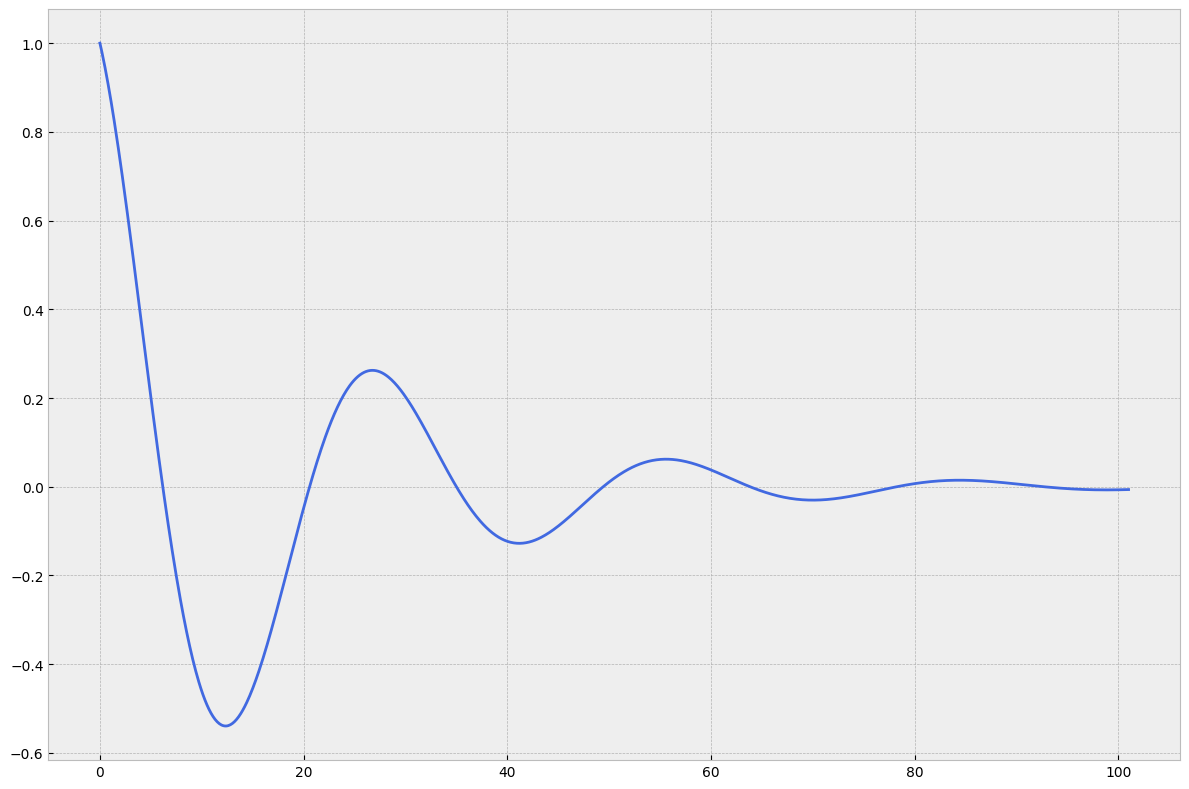

In [442]:
interact(
    main,
    A=FloatSlider(min=-5, max=5, step=0.1, value=0, description='A', style=style, layout=slider_layout),
    B=FloatSlider(min=-5, max=5, step=0.1, value=-0.1, description='B', style=style, layout=slider_layout),
    C=FloatSlider(min=-5, max=5, step=0.1, value=0.5, description='C', style=style, layout=slider_layout),
    D=FloatSlider(min=-5, max=5, step=0.1, value=-0.1, description='D', style=style, layout=slider_layout),
    x_0=FloatSlider(min=0, max=10, step=1, value=1, description='x_0', style=style, layout=slider_layout),
    y_0=FloatSlider(min=0, max=10, step=1, value=1, description='y_0', style=style, layout=slider_layout),
    days=IntSlider(min=1, max=360, step=10, value=101, description='t', style=style, layout=slider_layout),
);

AnalysisResults(equilibrium_x=0.0, equilibrium_y=0.0, natural_frequency=1.41332940251026, damping_ratio=0.0353553390593274, decay_rate=0.0500000000000000, trace=-0.100000000000000, determinant=2.00000000000000, discriminant=-7.99000000000000)
Eq(1.20491276383835*cos(phi), 1)


NameError: name 'amplitud_phase_form' is not defined

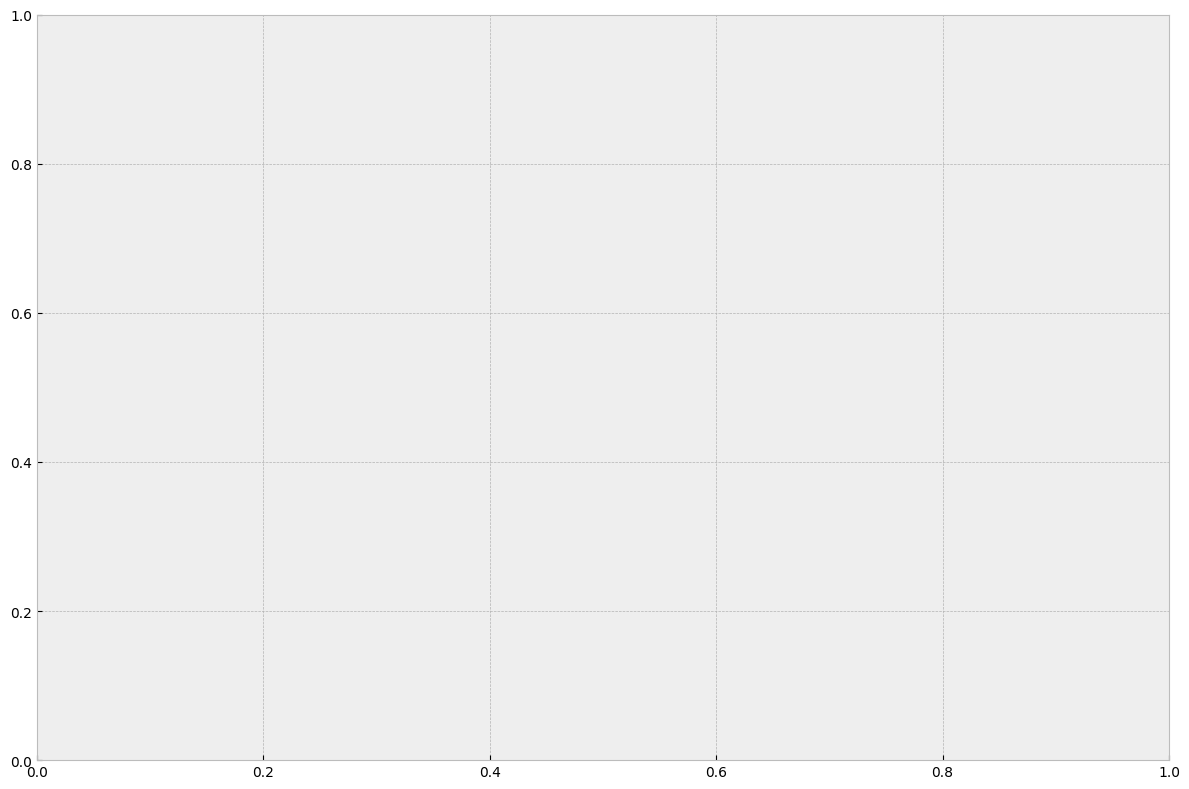

In [434]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=-0.10,
    x_0=1,
    y_0=1,
    days=100,
);

# Wave Characteristics

In [401]:
def get_particular_solution(coefficients, analysis_results, offset, amplitude, phase):
    C1, C2 = coefficients
    t = sy.symbols('t')

    alpha = round_expr(analysis_results.decay_rate)
    omega = round_expr(analysis_results.natural_frequency)
    
    exponential_decay = sy.exp(-alpha * t)
    cosine_component = np.round(C1, 2) * sy.cos(round_expr(analysis_results.natural_frequency) * t)
    sine_component = np.round(C2, 2) * sy.sin(round_expr(analysis_results.natural_frequency) * t)
    sine_cosine_form = f"{exponential_decay} ({cosine_component + sine_component})"

    amplitud_phase_form = f"{offset + sy.exp(-alpha * t) * np.round(amplitude, 2) * sy.cos(omega * t + np.round(phase, 3))}"
    
    return f"{sine_cosine_form}={amplitud_phase_form}"

In [643]:
def plot_wave_characteristics(time, solution, analysis_results, function, initial_conditions, initial_deltas):
    x_solution, y_solution = solution
    x_0, y_0 = initial_conditions
    delta_x_0, delta_y_0 = initial_deltas
    print(initial_deltas)
    
    fig, ax = plt.subplots(figsize=(12, 8), layout="tight")

    system_has_oscillations = 0 < analysis_results.damping_ratio < 1

    
    if system_has_oscillations:
        x_coefficients = compute_solution_coefficients(x_0, delta_x_0, analysis_results.equilibrium_x, analysis_results)
        x_amplitude, x_period, x_phase_shift = compute_amplitude_and_shift(analysis_results, analysis_results.equilibrium_x, x_coefficients, x_0, delta_x_0)
        x_phase_shift_radians, x_phase_shift_time = x_phase_shift
        x_overshoot, x_undershoot = compute_ovoershoot(x_coefficients, analysis_results, analysis_results.equilibrium_x)

    x_overshoot_time, x_overshoot_value =  x_overshoot
    ax.axvline(x_overshoot_time, color="forestgreen", ls="-.")
    ax.axhline(x_overshoot_value, color="forestgreen", ls="-.")
    
    x_wave_form = get_particular_solution(x_coefficients, analysis_results, analysis_results.equilibrium_x, x_amplitude, x_phase_shift_radians)
    ax.plot(time, x_solution, label=f'$x(t): {x_wave_form}$', color="royalblue", lw=1)
    ax.axhline(analysis_results.equilibrium_x, color="royalblue", ls="--", lw=1)

    ax.axvline(x_phase_shift_time, color="royalblue", ls="--", lw=1)

    ys = analysis_results.equilibrium_x + np.exp(-float(analysis_results.decay_rate) * time) * x_amplitude * np.cos(float(analysis_results.natural_frequency) * time - x_phase_shift_radians)
    ax.plot(time, ys, ls="-.") 
    

    
    if system_has_oscillations:
        y_coefficients = compute_solution_coefficients(y_0, delta_y_0, analysis_results.equilibrium_y, analysis_results)
        y_amplitude, y_period, y_phase_shift = compute_amplitude_and_shift(analysis_results, analysis_results.equilibrium_y, y_coefficients, y_0, delta_y_0)
        y_phase_shift_radians, y_phase_shift_time = y_phase_shift
        y_overshoot, y_undershoot = compute_ovoershoot(y_coefficients, analysis_results, analysis_results.equilibrium_y)

    y_overshoot_time, y_overshoot_value = y_overshoot
    ax.axvline(y_overshoot_time, color="goldenrod", ls="-.")
    ax.axhline(y_overshoot_value, color="goldenrod", ls="-.")
    
    y_wave_form = get_particular_solution(y_coefficients, analysis_results, analysis_results.equilibrium_y, y_amplitude, y_phase_shift_radians)
    ax.plot(time, y_solution, label=f'$y(t): {y_wave_form}$', color="firebrick", lw=1)
    ax.axhline(analysis_results.equilibrium_y, color="firebrick", ls="--", lw=1)    

    ax.axvline(y_phase_shift_time, color="firebrick", ls="--", lw=1)

    ys = analysis_results.equilibrium_y + np.exp(-float(analysis_results.decay_rate) * time) * y_amplitude * np.cos(float(analysis_results.natural_frequency) * time - y_phase_shift_radians)
    ax.plot(time, ys, ls="-.") 
    
    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    
    handles += [proxy_artist]
    labels += [f"$A_x={x_amplitude:.2f}$   $A_y={y_amplitude:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$\phi_x={x_phase_shift_radians:.2f} rad = {x_phase_shift_time:.2f}s$   $\phi_y={y_phase_shift_radians:.2f} rad= {y_phase_shift_time:.2f}s$"]

    ax.legend(handles, labels, loc='best')
    ax.set_title("X and Y over Time")

    plt.show()   
    

In [644]:
def system(A, B, C, D, offset=(0, 0)):
    def function(S, time):
        x, y = S
        x_offset, y_offset = offset
        x_off = (x - x_offset)
        y_off = (y - y_offset)
        return [
            A * x_off + B * y_off,
            C * x_off + D * y_off
        ]
    return function

def main(A, B, C, D, x_0, y_0, days):
    function = system(A, B, C, D, (10, 100))

    initial_conditions = [x_0, y_0]
    
    anaysis_result = analyse(function)
    print(anaysis_result)
    
    time = np.linspace(0, days, days*10)
    initial_deltas = function(initial_conditions, 0)
    solution = odeint(function, initial_conditions, time).T

    plot_wave_characteristics(time, solution, anaysis_result, function, initial_conditions, initial_deltas)

AnalysisResults(equilibrium_x=10.0000000000000, equilibrium_y=100.000000000000, natural_frequency=0.217944947177034, damping_ratio=0.223606797749979, decay_rate=0.0500000000000000, trace=-0.100000000000000, determinant=0.0500000000000000, discriminant=-0.190000000000000)
[2.75, 15.5]
general_solution=20.0000000000000
amplitude_phase_form_equation=17.9546211614902*cos(phi) + 10.0
phase_shift_radians=0.980075699606398
phase_shift_time=4.49689571747812
overshoot=(3.46216924724273, 24.71831179034059)
undershoot=(61.1206319788962, 10.823797346515489)
general_solution=45.0000000000000
amplitude_phase_form_equation=80.2955068546966*cos(phi) + 100.0
phase_shift_radians=2.325358620503165
phase_shift_time=10.6694770886994
overshoot=(9.63475061846402, 148.3433893091065)
undershoot=(24.0493663013774, 76.48593617840166)


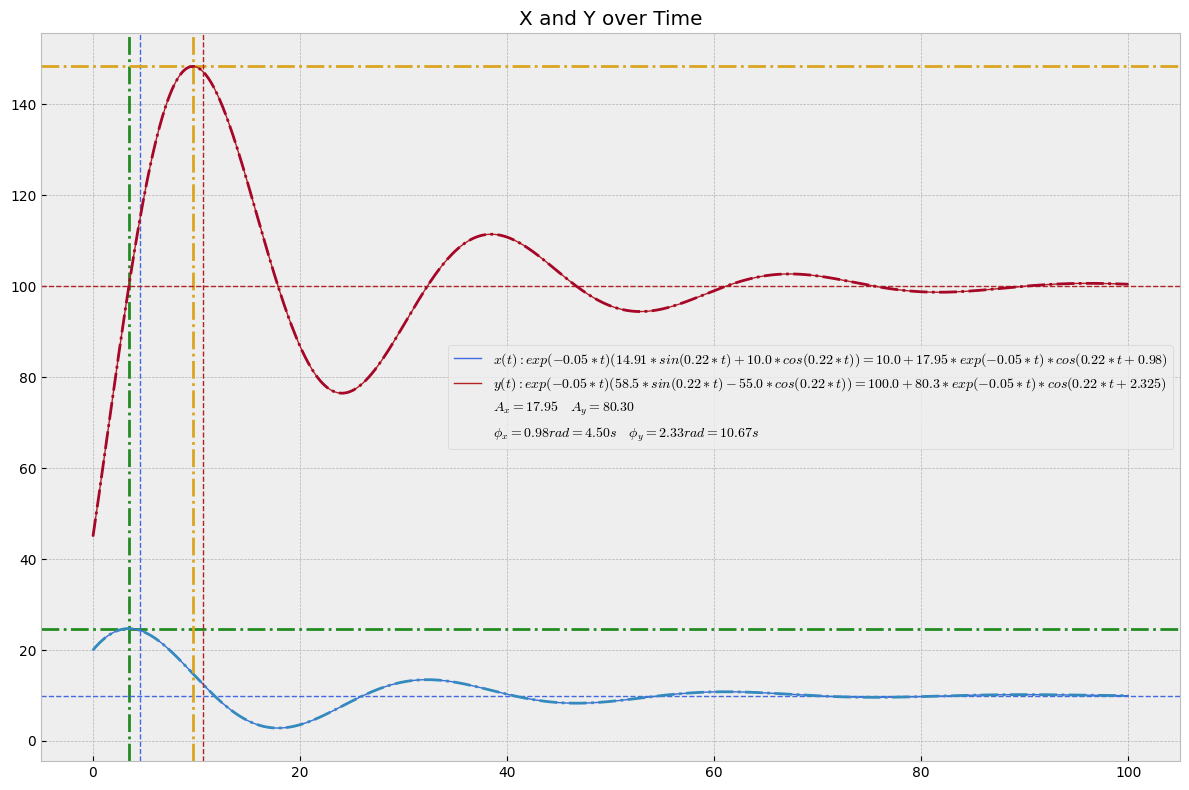

In [645]:
main(
    A=0,
    B=-0.05,
    C=1.00,
    D=-0.10,
    x_0=20,
    y_0=45,
    days=100,
);

# Envelope

# Control Metrics